## Прогнозирование временного ряда с использованием XGBoost

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from xgboost import XGBRegressor

In [42]:
df = pd.read_csv('wine_Austral.dat', sep='\t')
df.tail()

,fort,dry,sweet,red,rose,spark,total,year_,month_,date_
170,1965,3754,187,2201,42,1720,23565,1994,3,MAR 1994
171,2659,3708,279,2455,48,1725,26323,1994,4,APR 1994
172,2354,3210,193,2204,44,1674,23779,1994,5,MAY 1994
173,2592,3517,227,2660,45,1693,27549,1994,6,JUN 1994
174,,,,,,,,1994,7,JUL 1994


In [43]:
df.drop(labels = [174],axis = 0, inplace = True)
df = df[["red", "month_"]]
df['red'] = df['red'].astype(float)

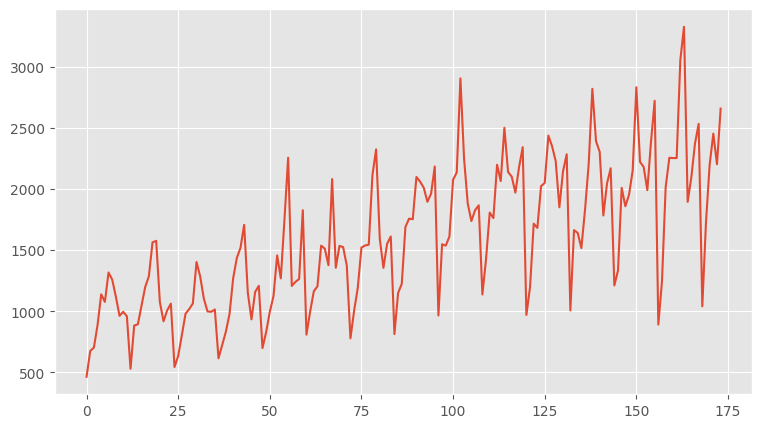

In [44]:
plt.figure(figsize=(9,5))
df['red'].plot();

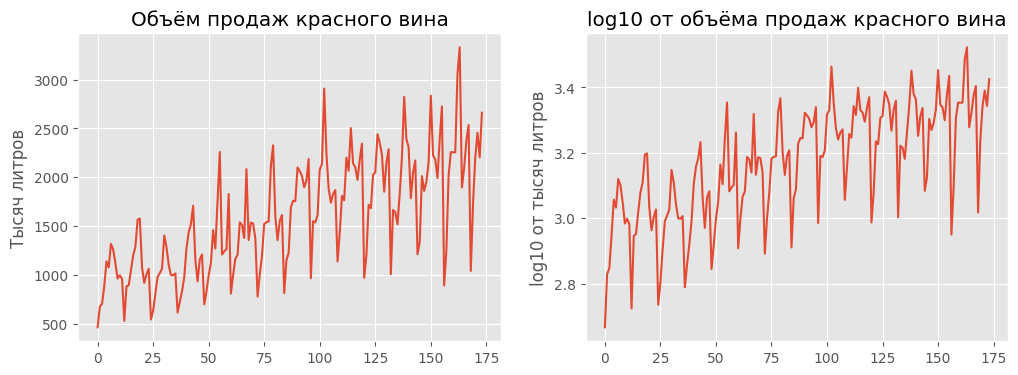

In [45]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['red'].plot(ax=ax1)
ax1.set_title(u'Объём продаж красного вина')
ax1.set_ylabel(u'Тысяч литров')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['red'])).plot(ax=ax2)
ax2.set_title(u'log10 от объёма продаж красного вина')
ax2.set_ylabel(u'log10 от тысяч литров');

In [46]:
df['log_y'] = np.log10(df['red'])
df['month_num'] = range(1, len(df) + 1)
df['month_num_2'] = df['month_num']**2
df = df.drop(columns=["red"])

Создадим новые переменные - индикаторы месяцев.

In [47]:
for i in range(1, 13):
    month_col = f'm{str(i).zfill(2)}'
    df[month_col] = (df['month_'] == i).astype(int)

df

,month_,log_y,month_num,month_num_2,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,1,2.666518,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2,2.829304,2,4,0,1,0,0,0,0,0,0,0,0,0,0
2,3,2.846955,3,9,0,0,1,0,0,0,0,0,0,0,0,0
3,4,2.947924,4,16,0,0,0,1,0,0,0,0,0,0,0,0
4,5,3.056524,5,25,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2,3.237544,170,28900,0,1,0,0,0,0,0,0,0,0,0,0
170,3,3.342620,171,29241,0,0,1,0,0,0,0,0,0,0,0,0
171,4,3.390051,172,29584,0,0,0,1,0,0,0,0,0,0,0,0
172,5,3.343212,173,29929,0,0,0,0,1,0,0,0,0,0,0,0


In [48]:
df = df.drop(columns=["month_"])

X = df.drop(columns=["log_y"])
y = df['log_y']

In [55]:
params = {'random_state':42,
          'n_estimators':200,
          'max_depth':24,
          'learning_rate':0.03
          }

model = XGBRegressor(**params)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=24, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

Сравним подгонку и логарифмированный ряд.

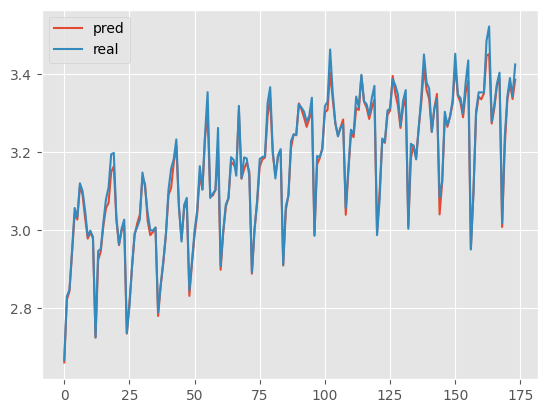

In [56]:
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot();

In [57]:
print("MSE = ", sum((y - model.predict(X))**2))

MSE =  0.05722602706872304


Создадим датафрейм для вычисления прогноза.

In [58]:
horizon = 4

df_3 = pd.DataFrame()
df_3['month_num'] = range((len(df)+1), (len(df)+horizon+1))
df_3['month_num_2'] = df_3['month_num']**2

In [59]:
df_3["m01"] = ([0,0,0,0,0,0,1,0,0,0,0,0])[0:horizon]
df_3["m02"] = ([0,0,0,0,0,0,0,1,0,0,0,0])[0:horizon]
df_3["m03"] = ([0,0,0,0,0,0,0,0,1,0,0,0])[0:horizon]
df_3["m04"] = ([0,0,0,0,0,0,0,0,0,1,0,0])[0:horizon]
df_3["m05"] = ([0,0,0,0,0,0,0,0,0,0,1,0])[0:horizon]
df_3["m06"] = ([0,0,0,0,0,0,0,0,0,0,0,1])[0:horizon]
df_3["m07"] = ([1,0,0,0,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m08"] = ([0,1,0,0,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m09"] = ([0,0,1,0,0,0,0,0,0,0,0,0])[0:horizon] 
df_3["m10"] = ([0,0,0,1,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m11"] = ([0,0,0,0,1,0,0,0,0,0,0,0])[0:horizon]
df_3["m12"] = ([0,0,0,0,0,1,0,0,0,0,0,0])[0:horizon]

In [60]:
df_3

,month_num,month_num_2,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,175,30625,0,0,0,0,0,0,1,0,0,0,0,0
1,176,30976,0,0,0,0,0,0,0,1,0,0,0,0
2,177,31329,0,0,0,0,0,0,0,0,1,0,0,0
3,178,31684,0,0,0,0,0,0,0,0,0,1,0,0


Прогноз для исходного ряда.

In [61]:
y1 = 10**model.predict(df_3)

In [62]:
pred['forecast'] = np.nan
pred.head()

,pred,real,forecast
0,2.659859,2.666518,NaN
1,2.821501,2.829304,NaN
2,2.842743,2.846955,NaN
3,2.944447,2.947924,NaN
4,3.042746,3.056524,NaN


In [63]:
df_4 = pd.DataFrame(a2, columns=['forecast'])
df_4['real'] = np.nan
df_4['pred'] = np.nan

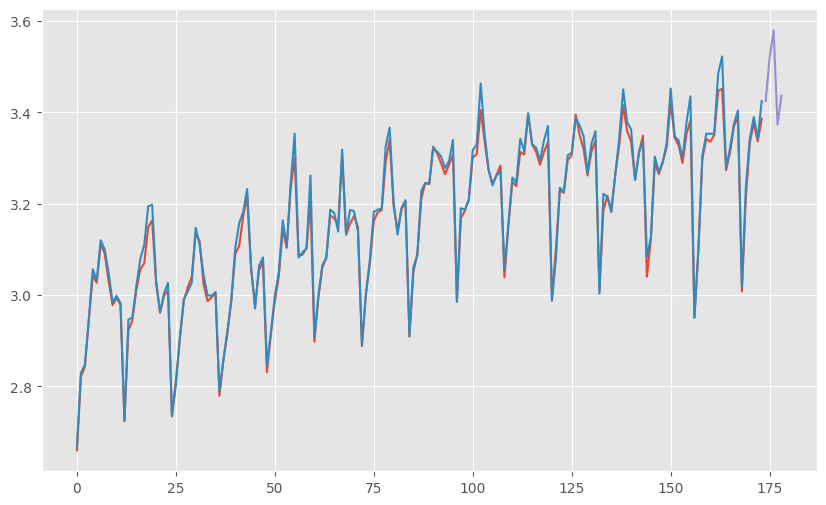

In [64]:
pred_1 = pd.concat(
    [pred, df_4],
    sort=False
).reset_index(drop=True)

plt.figure(figsize=(10,6))
plt.plot(pred_1)
plt.show()

Возвращаемся к исходному ряду.

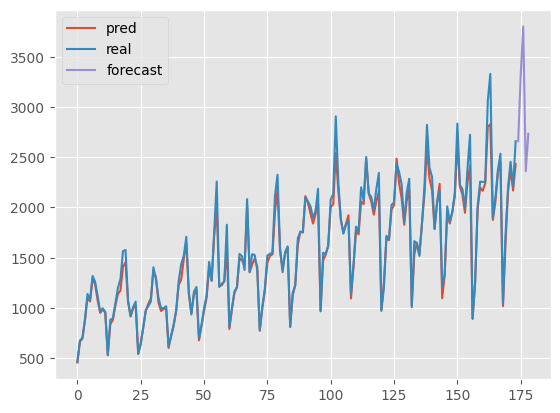

In [65]:
pred_2 = 10**pred_1
pred_2.plot();